In [1]:
RUNNING_IN_COLAB = False

if RUNNING_IN_COLAB:
    REPO_URL = 'https://github.com/nicomem/imed-project.git'
    BRANCH   = 'master'
    REPO_DIR = 'imed-project'
    DATA_URL = 'https://drive.google.com/uc?id=1onHHWIhkhN5xYMit0rhhtVXlJrAlzCit'
    
    from pathlib import Path

    %cd /content

    # Download the repository
    if not Path(REPO_DIR).is_dir():
        !git clone --branch {BRANCH} --depth=1 -- {REPO_URL} {REPO_DIR}
    
    %cd {REPO_DIR}

    # Install requirements
    !pip install -r requirements.txt | grep -v 'Requirement already satisfied'
    !pip install gdown | grep -v 'Requirement already satisfied'
    
    import gdown
    if not Path('data.zip').is_file():
        gdown.download(DATA_URL, 'data.zip', quiet=False)
    
    if not Path('data').is_dir():
        !unzip -q -- data.zip
    
    %cd notebooks
    %ls

## Imports

In [2]:
# 3rd-party imports
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_unet

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


## Get dataset & split train/test

In [3]:
from utils.load_data import get_dataset, SlicesSequence, CachedSlices3DSequence

train_nib, val_nib, test_nib = get_dataset('../data', verbose=True)

print('\n{...}_nib keys:', train_nib.keys())
print('train_nib:', [len(v) for v in train_nib.values()])
print('val_nib:',   [len(v) for v in val_nib.values()])
print('test_nib:',  [len(v) for v in test_nib.values()])

Number of files for each category: 60
Train/val/test split: 48 / 6 / 6

{...}_nib keys: dict_keys(['3DT1', 'FLAIR', 'T1', 'wmh'])
train_nib: [48, 48, 48, 48]
val_nib: [6, 6, 6, 6]
test_nib: [6, 6, 6, 6]


## Load train & analyze

In [6]:
batch_size = 16
shuffle = True
preprocess = True
target_height = 256
target_width = 256
img_size = (target_height, target_width)
num_classes = 1
num_channels_per_slice = 2 + preprocess
radius_3D = 1
total_num_channels = (radius_3D * 2 + 1) * num_channels_per_slice # both sides (*2) + origin times channels per slice

train_seq_uncached = SlicesSequence(train_nib,
                                    target_height=target_height,
                                    target_width=target_width, 
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    slices3D_radius=radius_3D)
train_seq = CachedSlices3DSequence(train_seq_uncached, remove_no_wmh=True, preprocess=preprocess)

print('Number of batch:', len(train_seq))
print('Total number of slices:', len(train_seq.Y))
print(len(train_seq.indexes))

Number of batch: 69
Total number of slices: 48
1110


In [7]:
train_seq.__getitem__(0)[0].shape,train_seq.__getitem__(0)[1].shape

((16, 256, 256, 9), (16, 256, 256))

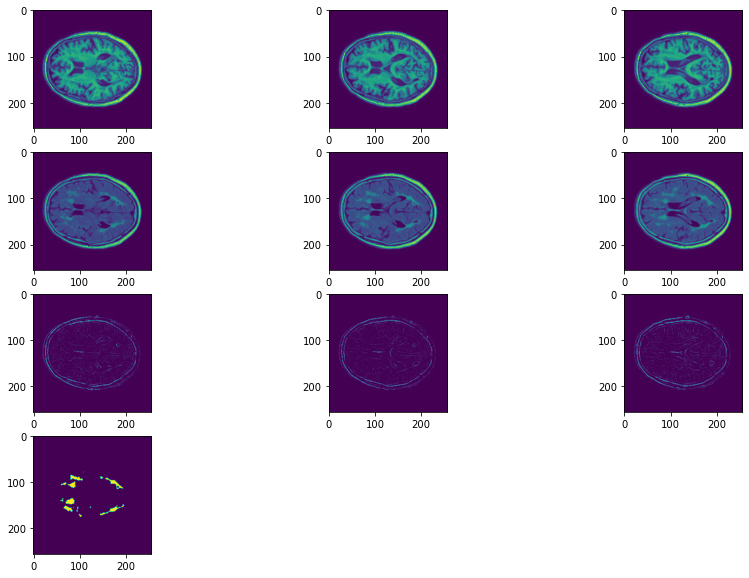

In [9]:
# Plotting a random slice from 2 batchs

plt.figure(figsize=(15, 10))
i_data = 12

x,y = train_seq[0]
plt.subplot(4, 3, 1); plt.imshow(x[i_data,...,0])
plt.subplot(4, 3, 2); plt.imshow(x[i_data,...,1])
plt.subplot(4, 3, 3); plt.imshow(x[i_data,...,2])
plt.subplot(4, 3, 4); plt.imshow(x[i_data,...,3])
plt.subplot(4, 3, 5); plt.imshow(x[i_data,...,4])
plt.subplot(4, 3, 6); plt.imshow(x[i_data,...,5])
plt.subplot(4, 3, 7); plt.imshow(x[i_data,...,6])
plt.subplot(4, 3, 8); plt.imshow(x[i_data,...,7])
plt.subplot(4, 3, 9); plt.imshow(x[i_data,...,8])
plt.subplot(4, 3, 10); plt.imshow(y[i_data])

## Create the model

In [ ]:
from keras_unet.models import custom_unet

input_shape = (target_height, target_width, total_num_channels)
tf.keras.backend.clear_session()
model = custom_unet(
    input_shape,
    num_classes=1,
    use_batch_norm=True,
    filters=32,
    num_layers=3,
    dropout=0.1,
    output_activation='sigmoid'
)
model.summary()

## Train the model

In [ ]:
val_seq_uncached = SlicesSequence(val_nib,
                                  target_height=target_height,
                                  target_width=target_width, 
                                  batch_size=batch_size,
                                  shuffle=shuffle,
                                  slices3D_radius=radius_3D)
val_seq = CachedSlices3DSequence(val_seq_uncached, preprocess=preprocess)
len(val_seq)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss="binary_crossentropy",
    metrics=[
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='AUC')
    ]
)

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_filename = 'segm_model_v0.h5'
callback_checkpoint = ModelCheckpoint(
    checkpoint_filename, 
    verbose=1, 
    monitor='val_AUC',
    mode='max',
    save_best_only=True,
)

In [ ]:
history = model.fit(
    train_seq,
    epochs=40,
    validation_data=val_seq,
    #batch_size=32,
    shuffle=True,
    callbacks=[callback_checkpoint]
)

## Results

In [ ]:
# Display the learning curves with a rolling average (to make the plots easier to analyse)

def rolling_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

ravg_w = 3

plot_cols = ['loss', 'precision', 'recall']
plt.figure(figsize=(20,6))
for i, col in enumerate(plot_cols):
    plt.subplot(1, len(plot_cols), i+1)

    plt.plot(rolling_average(history.history[col], ravg_w), label='train')
    plt.plot(rolling_average(history.history[f'val_{col}'], ravg_w), label='val')

    plt.title(col)
    plt.xlabel('Epoch')
    plt.ylabel(col)
    plt.legend()

plt.show()

## Evaluating the model

In [ ]:
def check_model_with_set(model, seq, N = 10, bool_threshold = None):
    '''
    Display the model results on a random sample of data.
    
    Parameters:
    -----------
    model:
        The trained model.
    seq: SlicesSequence
        The dataset to check.
    N: int
        The number of samples to check.
    bool_threshold: Option[int]
        The threshold to apply to the model results.
        Must be in the range: [0.0, 1.0].
        Set to None to display the raw results (probabilities).
    '''
    
    # Pick a random sample of the dataset
    i_samples = np.random.choice(np.arange(0, len(seq.X)), size=N, replace=False)
    
    # Predict the samples
    X = seq.X[i_samples]
    Y_gt = seq.Y[i_samples]
    Y_pred = model.predict(X)

    if bool_threshold:
        Y_pred = (Y_pred > bool_threshold).astype(np.bool)

    # Helper function to reshape the images, in case there are more single dimensions
    reshape_img = lambda img: np.reshape(img, (target_height, target_width))
        
    # Compare some predictions to the ground truth
    plt.figure(figsize=(20,5*N))
    for i in range(N):
        x_T1    = reshape_img(X[i,...,0])
        x_FLAIR = reshape_img(X[i,...,1])
        y_gt    = reshape_img(Y_gt[i])
        y_pred  = reshape_img(Y_pred[i])

        plt.subplot(N, 4, 4*i+1)
        plt.imshow(x_T1)
        plt.title('T1')

        plt.subplot(N, 4, 4*i+2)
        plt.imshow(x_FLAIR)
        plt.title('FLAIR')

        plt.subplot(N, 4, 4*i+3)
        plt.imshow(y_gt)
        plt.title('Ground Truth (wmh)')

        plt.subplot(N, 4, 4*i+4)
        plt.imshow(y_pred)
        plt.title('Predicted (wmh)')

In [ ]:
# Fetch the test set
test_seq_uncached = SlicesSequence(test_nib,
                                   target_height=target_height,
                                   target_width=target_width, 
                                   batch_size=batch_size,
                                   shuffle=shuffle,
                                   slices3D_radius=radius_3D)
test_seq = CachedSlices3DSequence(val_seq_uncached, preprocess=preprocess)
print('Number of slices in test set:', len(test_seq) * batch_size)

In [ ]:
model.evaluate(test_seq)

In [ ]:
# check_model_with_set(model, test_seq, N=20, bool_threshold=0.5)